In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import xarray as xr
import copy
import os
import sys
import metrics
import random
import scipy.stats as st
import matplotlib 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
# Convert flow to   CFS mm -> ft     km^2 -> ft^2    hr->s
conversion_factor = 0.00328084 * 10763910.41671 / 3600 / 24

In [3]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [4]:
# Camels attributes with RI information
dataName = '../data/camels_attributes.csv'
# load the data with pandas
pd_attributes = pd.read_csv(dataName, sep=',', index_col='gauge_id')

# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in pd_attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
pd_attributes['basin_id_str'] = basin_id_str

In [5]:
def calculate_all_metrics_for_frequency_analysis(analysis_dict, flows):
    
    sims = list(flows.keys())[:-1]

    for metric in metrics.get_available_metrics():

        score = {sim:0 for sim in sims}
        
        if metric == 'NSE':
            for sim in sims:
                score[sim] = metrics.nse(flows['obs'],flows[sim])
        if metric == 'MSE':
            for sim in sims:
                score[sim] = metrics.mse(flows['obs'],flows[sim])
        if metric == 'RMSE':
            for sim in sims:
                 score[sim] = metrics.rmse(flows['obs'],flows[sim])
        if metric == 'KGE':
            for sim in sims:
                score[sim] = metrics.kge(flows['obs'],flows[sim])
        if metric == 'KGEss':
            for sim in sims:
                score[sim] = (metrics.kge(flows['obs'],flows[sim])+0.41421356237)/np.sqrt(2)
        if metric == 'Alpha-NSE':
            for sim in sims:
                score[sim] = metrics.alpha_nse(flows['obs'],flows[sim])
        if metric == 'Beta-NSE':
            for sim in sims:
                score[sim] = metrics.beta_nse(flows['obs'],flows[sim])
        if metric == 'Pearson-r':
            for sim in sims:
                score[sim] = metrics.pearsonr(flows['obs'],flows[sim])
        if metric == 'Peak-Timing':
            for sim in sims:
                score[sim] = np.abs(metrics.mean_peak_timing(flows['obs'],flows[sim]))
        if metric == 'FHV':
            for sim in sims:
                score[sim] = metrics.fdc_fhv(flows['obs'],flows[sim])          
        if metric == 'FLV':
            for sim in sims:
                score[sim] = metrics.fdc_flv(flows['obs'],flows[sim])          
        if metric == 'FMS':
            for sim in sims:
                score[sim] = metrics.fdc_fms(flows['obs'],flows[sim])          
          
        for sim in sims:
            analysis_dict[metric][sim].append(score[sim])
        
    return

# ---------------------------------
# Standard Time Split

test period(1989-1999) is the same period used by previous studies  which allows us to confirm that the deep learning models (LSTM andMC-LSTM) trained for this project perform as expected relative to prior work. 
These metrics are broadly equivalent to thosereported for single models (not ensembles) by (Kratzert et al., 2019c) (LSTM) and (Hoedt et al., 2021) (MC-LSTM)

# Standard Time Split
# ---------------------------------

In [6]:
#-------------------------------------------------------------------------------------------------
# Set up lists to use in loops
models =        ['lstm','mc', 'sac']
flows =         ['lstm','mc', 'sac', 'obs']
#-------------------------------------------------------------------------------------------------

lstm_results_time_split1   = {}
mclstm_results_time_split1 = {}
sacsma_results_time_split1 = {}
for forcing_type in ['nldas', 'daymet']:

    with open('./model_output_for_analysis/lstm_time_split1_{}_ens.p'.format(forcing_type), 'rb') as fb:
        lstm_results_time_split1[forcing_type] = pkl.load(fb)
    with open('./model_output_for_analysis/mclstm_time_split1_{}_ens.p'.format(forcing_type), 'rb') as fb:
        mclstm_results_time_split1[forcing_type] = pkl.load(fb)
    with open('./model_output_for_analysis/sacsma_time_split1_{}_ens.p'.format(forcing_type), 'rb') as fb:
        sacsma_results_time_split1[forcing_type] = pkl.load(fb)
    
basin_list = lstm_results_time_split1[forcing_type].keys()

st1_dict = {}

for forcing_type in ['nldas', 'daymet']:

    analysis_dict_temp_large = {}
    #-------------------------------------------------------------------------------------------------            

    #-------------------------------------------------------------------------------------------------
    #-----LOOP THROUGH BASINS------------------------------------------------------------------------
    #-------------------------------------------------------------------------------------------------

    for ib, basin_0str in enumerate(basin_list): 
        basin_int = int(basin_0str)



        #-------------------------------------------------------------------------------------------------
        # Setting up the dictionary for the single basin results. Then will add to the overall dict.
        analysis_dict_temp_small = {metric:{model:[] for model in models} for metric in metrics.get_available_metrics()}
        #-------------------------------------------------------------------------------------------------


        #-------------------------------------------------------------------------------------------------
        # We need the basin area to convert to CFS, to interpolate the RI from LPIII
        basin_area = pd_attributes.loc[basin_int, 'area_geospa_fabric']
        basin_str = str(basin_int).zfill(8)
        #-------------------------------------------------------------------------------------------------


        #-------------------------------------------------------------------------------------------------
        #----  Set the time period for metrics   ---------------------------------------------------------
        date_from = '1989-10'
        date_to = '1999-09'
        #-------------------------------------------------------------------------------------------------    

        #-------------------------------------------------------------------------------------------------
        # Make dictionary with all the flows
        flow_mm = {}
        #-------------------------------------------------------------------------------------------------


        #-------------------------------------------------------------------------------------------------
        # Standard LSTM data trained on all years
        xrr = lstm_results_time_split1[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_sim']
        flow_mm['lstm'] = pd.DataFrame(data=xrr.values,index=xrr.datetime.values).loc[date_from:date_to]
        #-------------------------------------------------------------------------------------------------        
        # Mass Conserving LSTM data
        xrr = mclstm_results_time_split1[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_sim']
        flow_mm['mc'] = pd.DataFrame(data=xrr.values,index=xrr.datetime.values).loc[date_from:date_to]
        #-------------------------------------------------------------------------------------------------
        # SACSMA Sinlge run
        df = sacsma_results_time_split1[forcing_type][basin_0str]
        flow_mm['sac'] = df.loc[date_from:date_to]
        #-------------------------------------------------------------------------------------------------
        # OBSERVATIONS
        xrr = mclstm_results_time_split1[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs']
        flow_mm['obs'] = pd.DataFrame(data=xrr.values,index=xrr.datetime.values).loc[date_from:date_to]
        #-------------------------------------------------------------------------------------------------


        #-------------------------------------------------------------------------------------------------
        # Make all xarray data similar
        for iflow in flows:
            if iflow == 'nwm': #already in the correct format
                continue
            if iflow == 'sac': #already in the correct format
                flow_mm[iflow] = xr.DataArray(np.array(flow_mm[iflow].values, dtype='float32'), 
                               coords=dict(datetime=flow_mm[iflow].index.values), dims=['datetime'])
            else:
                flow_mm[iflow] = xr.DataArray(flow_mm[iflow].values[:,0], 
                               coords=dict(datetime=flow_mm[iflow].index.values), dims=['datetime'])
        #-------------------------------------------------------------------------------------------------


        #-------------------------------------------------------------------------------------------------
        calculate_all_metrics_for_frequency_analysis(analysis_dict_temp_small, flow_mm)
        #-------------------------------------------------------------------------------------------------


        #-------------------------------------------------------------------------------------------------
        #Now that the basin has been analyzed successfully, add it to the larger dictionary
        analysis_dict_temp_large[basin_0str] = analysis_dict_temp_small
        #------------------------------------------------------------------------------------------------- 

    st1_dict[forcing_type] = {metric:{model:[] for model in models} for metric in metrics.get_available_metrics()}
    for ib, basin_0str in enumerate(basin_list):
        try:
            for metric in metrics.get_available_metrics():
                for model in models:
                    st1_dict[forcing_type][metric][model].extend(analysis_dict_temp_large[basin_0str][metric][model])
        except:
            continue


/home/jmframe/programs/anaconda3/envs/mc-paper/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/jmframe/programs/anaconda3/envs/mc-paper/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/jmframe/programs/anaconda3/envs/mc-paper/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/jmframe/programs/anaconda3/envs/mc-paper/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning

In [7]:
if True:
    with open("statistics_table_st1.pkl", 'wb') as fb:
        pkl.dump(st1_dict, fb)
else:
    with open('statistics_table_st1.pkl', 'rb') as fb:
        st1_dict = pkl.load(fb)

In [8]:
table_metrics = ['NSE','KGE','Pearson-r','Alpha-NSE','Beta-NSE','FHV','FLV','FMS']

In [9]:
lower_bound_st1_dict = {metric:{} for metric in table_metrics}
kgess_st1_dict = {forcing_type:{} for forcing_type in ['daymet','nldas']}
for metric in table_metrics:
    for forcing_type in ['daymet','nldas']:
        lower_bound_st1_dict[metric][forcing_type] = (np.array(st1_dict[forcing_type][metric]["lstm"]) - \
                                                        np.array(st1_dict[forcing_type][metric]["mc"])) / \
                                                       (np.array(st1_dict[forcing_type][metric]["lstm"]) - \
                                                        np.array(st1_dict[forcing_type][metric]["sac"]))            
            
for forcing_type in ['daymet','nldas']:
    kgess_st1_dict[forcing_type]['MC-LSTM'] = (np.array(st1_dict[forcing_type]["KGE"]["mc"]) - \
                                                    np.array(st1_dict[forcing_type]["KGE"]["lstm"])) / \
                                                   (1 - np.array(st1_dict[forcing_type]["KGE"]["lstm"]))                        
for forcing_type in ['daymet','nldas']:
    kgess_st1_dict[forcing_type]['SAC-SMA'] = (np.array(st1_dict[forcing_type]["KGE"]["sac"]) - \
                                                    np.array(st1_dict[forcing_type]["KGE"]["lstm"])) / \
                                                   (1 - np.array(st1_dict[forcing_type]["KGE"]["lstm"]))                                    

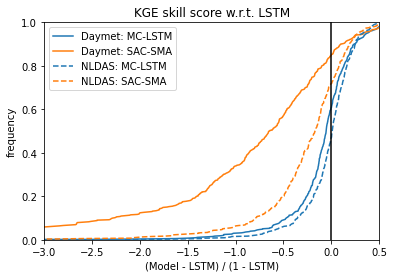

In [10]:
colz = ['#1f77b4', '#ff7f0e', '#2ca02c', '#bdbdbd']

yvalues = list(range(len(kgess_st1_dict['daymet']['SAC-SMA'])))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)        

    
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.sort(kgess_st1_dict['daymet']['MC-LSTM']), yvalues, label='Daymet: MC-LSTM', c=colz[0])
ax.plot(np.sort(kgess_st1_dict['daymet']['SAC-SMA']), yvalues, label='Daymet: SAC-SMA', c=colz[1])
ax.plot(np.sort(kgess_st1_dict['nldas']['MC-LSTM']), yvalues, label='NLDAS: MC-LSTM', c=colz[0], ls='--')
ax.plot(np.sort(kgess_st1_dict['nldas']['SAC-SMA']), yvalues, label='NLDAS: SAC-SMA', c=colz[1], ls='--')
ax.plot([0,0], [0,1], c='k')
ax.set_xlim([-3,.5])
ax.set_ylim([0,1])
plt.legend()
plt.title("KGE skill score w.r.t. LSTM")
plt.xlabel("(Model - LSTM) / (1 - LSTM)")
plt.ylabel("frequency")

plt.show()
plt.close()

Text(0, 0.5, 'frequency')

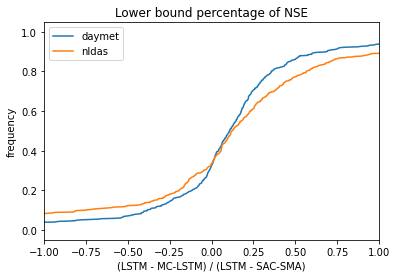

In [11]:
yvalues = list(range(len(lower_bound_st1_dict['NSE']['daymet'])))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)        

df_plot = pd.DataFrame(data=lower_bound_st1_dict['NSE'], columns=['daymet','nldas'])
plt.plot(np.sort(df_plot[~pd.isnull(df_plot)], axis=0), yvalues)
plt.xlim([-1,1])
plt.legend(['daymet','nldas'])
plt.title("Lower bound percentage of NSE")
plt.xlabel("(LSTM - MC-LSTM) / (LSTM - SAC-SMA)")
plt.ylabel("frequency")

metric NSE
forcing_type daymet
wilcoxon p value 0.0
forcing_type nldas
wilcoxon p value 0.0


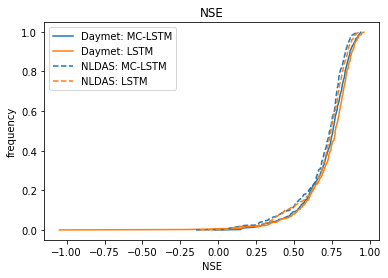

metric KGE
forcing_type daymet
wilcoxon p value 0.0
forcing_type nldas
wilcoxon p value 0.36


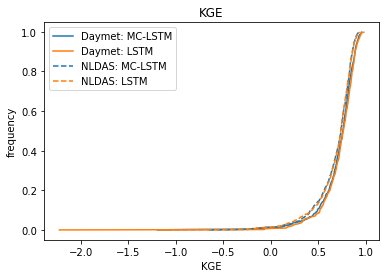

metric Pearson-r
forcing_type daymet
wilcoxon p value 0.0
forcing_type nldas
wilcoxon p value 0.0


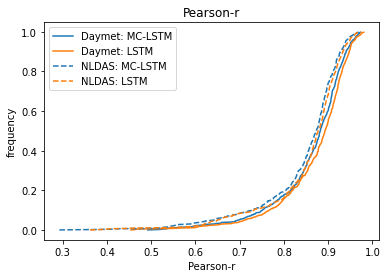

metric Alpha-NSE
forcing_type daymet
wilcoxon p value 0.0
forcing_type nldas
wilcoxon p value 0.0


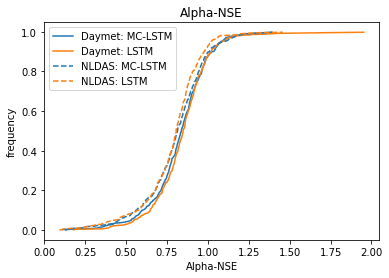

metric Beta-NSE
forcing_type daymet
wilcoxon p value 0.0
forcing_type nldas
wilcoxon p value 0.0


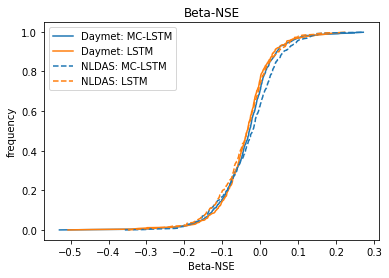

metric FHV
forcing_type daymet
wilcoxon p value 0.09
forcing_type nldas
wilcoxon p value 0.0


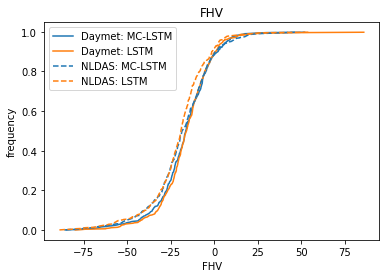

metric FLV
forcing_type daymet
wilcoxon p value 0.0
forcing_type nldas
wilcoxon p value 0.0


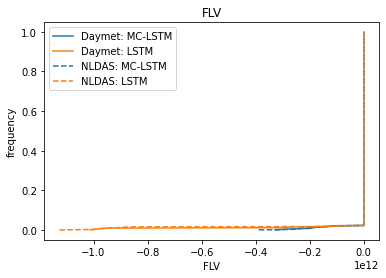

metric FMS
forcing_type daymet
wilcoxon p value 0.0
forcing_type nldas
wilcoxon p value 0.66


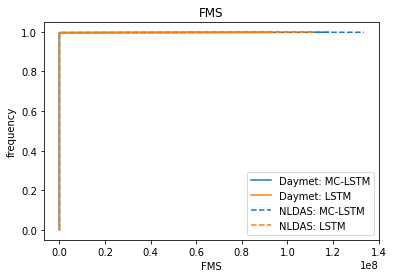

In [12]:
for metric in table_metrics:
    print("metric", metric)
    metric_dict = {forcing_type:{} for forcing_type in ['daymet','nldas']}
    for forcing_type in ['daymet','nldas']:
        print("forcing_type", forcing_type)
        _, wilcoxon_p = st.wilcoxon(st1_dict[forcing_type][metric]["mc"],
                                     st1_dict[forcing_type][metric]["lstm"])
        print("wilcoxon p value", np.round(wilcoxon_p,2))
        metric_dict["mc"] = st1_dict[forcing_type][metric]["mc"]
        metric_dict["lstm"] = st1_dict[forcing_type][metric]["lstm"]
        
    fig = plt.figure()
    ax = fig.add_subplot()

    ax.plot(np.sort(st1_dict['daymet'][metric]['mc']), yvalues, label='Daymet: MC-LSTM', c=colz[0])
    ax.plot(np.sort(st1_dict['daymet'][metric]['lstm']), yvalues, label='Daymet: LSTM', c=colz[1])
    ax.plot(np.sort(st1_dict['nldas'][metric]['mc']), yvalues, label='NLDAS: MC-LSTM', c=colz[0], ls='--')
    ax.plot(np.sort(st1_dict['nldas'][metric]['lstm']), yvalues, label='NLDAS: LSTM', c=colz[1], ls='--')
    plt.legend()
    plt.title(metric)
    plt.xlabel(metric)
    plt.ylabel("frequency")

    plt.show()
    plt.close()

In [13]:
data=st1_dict['daymet'][metric]['lstm']
st.t.interval(alpha=0.95, df=len(data)-1, loc=0, scale=st.sem(data))

(-344152.3776321693, 344152.3776321693)

In [15]:
#table_metrics = ['NSE','KGE','Pearson-r','Alpha-NSE','Beta-NSE','FHV','FLV','FMS']
round_to = 2
for metric in table_metrics:
    
    printstuf = {forcing_type:{model:{} for model in ['lstm', 'mc','sac']} for forcing_type in ['daymet','nldas']}

    for forcing_type in ['daymet','nldas']:
        for model in ['lstm', 'mc','sac']:
            data=st1_dict[forcing_type][metric][model]
            printstuf[forcing_type][model]['mean']=np.round(np.nanmedian(data),round_to)
            if np.abs(st.t.interval(alpha=0.95, df=len(data)-1,loc=0,scale=st.sem(data))[0]) < \
                np.abs(printstuf[forcing_type][model]['mean']):
                conf = np.round(st.t.interval(alpha=0.95, df=len(data)-1, loc=0,scale=st.sem(data))[0],round_to)
            else:
                conf = 'n/a'
            printstuf[forcing_type][model]['conf']=conf
    
    
    print('{}  &{} $\pm$ {} &{} $\pm$ {} &{} $\pm$ {} &{} $\pm$ {} &{} $\pm$ {} &{} $\pm{}$ \\'.format(metric,
                      printstuf['daymet']['lstm']['mean'],printstuf['daymet']['lstm']['conf'],
                                                                               
                      printstuf['daymet']['mc']['mean'],printstuf['daymet']['mc']['conf'],
                                                                               
                      printstuf['daymet']['sac']['mean'],printstuf['daymet']['sac']['conf'],
                                                
                      printstuf['nldas']['lstm']['mean'],printstuf['nldas']['lstm']['conf'],
                      
                      printstuf['nldas']['mc']['mean'],printstuf['nldas']['mc']['conf'],
                                                                               
                      printstuf['nldas']['sac']['mean'],printstuf['nldas']['sac']['conf']))
                                            
printstuf = {forcing_type:{model:{} for model in ['lstm', 'mc','sac']} for forcing_type in ['daymet','nldas']}
for forcing_type in ['daymet','nldas']:
    for model in ['lstm', 'mc','sac']:
        data=st1_dict[forcing_type]['Peak-Timing'][model]
        printstuf[forcing_type][model]['mean']=np.round(np.nanmedian(data),round_to)
        printstuf[forcing_type][model]['conf']=np.round(st.t.interval(alpha=0.95, 
                                                             df=len(data)-1,
                                                             loc=0,scale=st.sem(data))[0],round_to)
print('Peak-Timing &{} $\pm{}$ &{} $\pm{}$ &{} $\pm{}$ &{} $\pm{}$ &{} $\pm${} &{} $\pm$ {}\\'.format(
                      printstuf['daymet']['lstm']['mean'],printstuf['daymet']['lstm']['conf'],
                                                                               
                      printstuf['daymet']['mc']['mean'],printstuf['daymet']['mc']['conf'],
                                                                               
                      printstuf['daymet']['sac']['mean'],printstuf['daymet']['sac']['conf'],
                                                
                      printstuf['nldas']['lstm']['mean'],printstuf['nldas']['lstm']['conf'],
                      
                      printstuf['nldas']['mc']['mean'],printstuf['nldas']['mc']['conf'],
                                                                               
                      printstuf['nldas']['sac']['mean'],printstuf['nldas']['sac']['conf']))

NSE  &0.77 $\pm$ -0.02 &0.76 $\pm$ -0.01 &0.65 $\pm$ -0.03 &0.74 $\pm$ -0.01 &0.74 $\pm$ -0.01 &0.67 $\pm-0.02$ \
KGE  &0.76 $\pm$ -0.02 &0.76 $\pm$ -0.02 &0.59 $\pm$ n/a &0.74 $\pm$ -0.02 &0.74 $\pm$ -0.02 &0.68 $\pm-0.02$ \
Pearson-r  &0.89 $\pm$ -0.01 &0.88 $\pm$ -0.01 &0.83 $\pm$ n/a &0.88 $\pm$ -0.01 &0.87 $\pm$ -0.01 &0.83 $\pm-0.01$ \
Alpha-NSE  &0.85 $\pm$ -0.01 &0.84 $\pm$ -0.01 &0.76 $\pm$ -0.02 &0.81 $\pm$ -0.02 &0.81 $\pm$ -0.02 &0.78 $\pm-0.02$ \
Beta-NSE  &-0.04 $\pm$ -0.01 &-0.03 $\pm$ -0.01 &0.06 $\pm$ -0.01 &-0.03 $\pm$ -0.01 &-0.02 $\pm$ -0.01 &-0.01 $\pm-0.01$ \
FHV  &-16.04 $\pm$ -1.32 &-16.42 $\pm$ -1.38 &-21.28 $\pm$ -2.05 &-19.17 $\pm$ -1.44 &-18.57 $\pm$ -1.52 &-21.31 $\pm-1.77$ \
FLV  &26.11 $\pm$ n/a &-14.54 $\pm$ n/a &53.17 $\pm$ n/a &24.11 $\pm$ n/a &-17.75 $\pm$ n/a &46.33 $\pmn/a$ \
FMS  &-6.15 $\pm$ n/a &-9.96 $\pm$ n/a &-39.27 $\pm$ n/a &-9.93 $\pm$ n/a &-10.4 $\pm$ n/a &-15.53 $\pmn/a$ \
Peak-Timing &0.3 $\pm-0.03$ &0.3 $\pm-0.03$ &0.38 $\pm-0.06$ &0.32

# ---------------------------------
# NWM Time Split

The second test period (1995-2014) allows us to benchmark against the NWM-Rv2,  which does not provide data prior to2851995. Most of these scores are broadly  equivalent to the metrics for the same models reported for the test period 1989-1999, with the exception of the FHV (high flow bias), FLV (low flow bias), add FMS (flow duration curve bias).  These metrics dependheavily on the observed flow characteristics during a particular test period and,  because they are less stable, are somewhat lessuseful in terms of drawing general conclusions.  We report them here primarily for continuity with previous studies (Kratzertet al., 2019c, b, 2020;  Frame et al., 2020; Nearing et al., 2020b; Klotz et al., 2021; Gauch et al., 2021a), and one of the  objectives of this paper (Section 2.4 is to expand on the high flow (FHV) analysis specifically

# NWM Time Split
# ---------------------------------

In [16]:
#-------------------------------------------------------------------------------------------------
# Set up lists to use in loops
models =        ['nwm', 'lstm','mc', 'sac']
flows =         ['nwm', 'lstm','mc', 'sac', 'obs']
#-------------------------------------------------------------------------------------------------

lstm_results_time_split2 = {}
mclstm_results_time_split2 = {}
sacsma_results_time_split2 = {}
for forcing_type in ['nldas', 'daymet']:
    with open('./model_output_for_analysis/lstm_time_split2_{}.p'.format(forcing_type), 'rb') as fb:
        lstm_results_time_split2[forcing_type] = pkl.load(fb)
    with open('./model_output_for_analysis/mclstm_time_split2_{}.p'.format(forcing_type), 'rb') as fb:
        mclstm_results_time_split2[forcing_type] = pkl.load(fb)
    with open('./model_output_for_analysis/sacsma_time_split2_{}.p'.format(forcing_type), 'rb') as fb:
        sacsma_results_time_split2[forcing_type] = pkl.load(fb)

with open('./model_output_for_analysis/nwm_chrt_v2_1d_local.p', 'rb') as fb:
    nwm_results = pkl.load(fb)
        
basin_list = sacsma_results_time_split2[forcing_type].keys()

st2_dict = {}

for forcing_type in ['nldas', 'daymet']:

    analysis_dict_temp_large = {}
    #-------------------------------------------------------------------------------------------------            

    #-------------------------------------------------------------------------------------------------
    #-----LOOP THROUGH BASINS------------------------------------------------------------------------
    #-------------------------------------------------------------------------------------------------

    for ib, basin_0str in enumerate(basin_list): 
        basin_int = int(basin_0str)


        #-------------------------------------------------------------------------------------------------
        # Get the NWM data for this basin in an xarray dataset.
        xr_nwm = xr.DataArray(nwm_results[basin_0str]['streamflow'].values, 
                 coords=[nwm_results[basin_0str]['streamflow'].index], 
                 dims=['datetime'])
        #-------------------------------------------------------------------------------------------------


        #-------------------------------------------------------------------------------------------------
        # Setting up the dictionary for the single basin results. Then will add to the overall dict.
        analysis_dict_temp_small = {metric:{model:[] for model in models} for metric in metrics.get_available_metrics()}
        #-------------------------------------------------------------------------------------------------


        #-------------------------------------------------------------------------------------------------
        # We need the basin area to convert to CFS, to interpolate the RI from LPIII
        basin_area = pd_attributes.loc[basin_int, 'area_geospa_fabric']
        basin_str = str(basin_int).zfill(8)
        #-------------------------------------------------------------------------------------------------


        #-------------------------------------------------------------------------------------------------
        #----  Set the time period for metrics   ---------------------------------------------------------
        date_from = '1996-10'
        date_to = '2014-09'
        #-------------------------------------------------------------------------------------------------    

        #-------------------------------------------------------------------------------------------------
        # Make dictionary with all the flows
        flow_mm = {}
        #-------------------------------------------------------------------------------------------------


        #-------------------------------------------------------------------------------------------------        
         # NWM data
        sim_nwm = xr_nwm.loc[date_from:date_to]
        # convert from CFS to mm/day
        # fm3/s * 3600 sec/hour * 24 hour/day / (m2 * mm/m)
        flow_mm['nwm'] = sim_nwm*3600*24/(basin_area*1000)
        #-------------------------------------------------------------------------------------------------
        # Standard LSTM data trained on all years
        xrr = lstm_results_time_split2[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_sim']
        flow_mm['lstm'] = pd.DataFrame(data=xrr.values,index=xrr.date.values).loc[date_from:date_to]
        #-------------------------------------------------------------------------------------------------        
        # Mass Conserving LSTM data
        xrr = mclstm_results_time_split2[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_sim']
        flow_mm['mc'] = pd.DataFrame(data=xrr.values,index=xrr.date.values).loc[date_from:date_to]
        #-------------------------------------------------------------------------------------------------
        # SACSMA Sinlge run
        df = sacsma_results_time_split2[forcing_type][basin_0str]
        flow_mm['sac'] = df.loc[date_from:date_to]
        #-------------------------------------------------------------------------------------------------
        # OBSERVATIONS
        xrr = mclstm_results_time_split2[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs']
        flow_mm['obs'] = pd.DataFrame(data=xrr.values,index=xrr.date.values).loc[date_from:date_to]
        #-------------------------------------------------------------------------------------------------


        #-------------------------------------------------------------------------------------------------
        # Make all xarray data similar
        for iflow in flows:
            if iflow == 'nwm': #already in the correct format
                continue
            if iflow == 'sac': #already in the correct format
                flow_mm[iflow] = xr.DataArray(np.array(flow_mm[iflow].values, dtype='float32'), 
                               coords=dict(datetime=flow_mm[iflow].index.values), dims=['datetime'])
            else:
                flow_mm[iflow] = xr.DataArray(flow_mm[iflow].values[:,0], 
                               coords=dict(datetime=flow_mm[iflow].index.values), dims=['datetime'])
        #-------------------------------------------------------------------------------------------------


        #-------------------------------------------------------------------------------------------------
        calculate_all_metrics_for_frequency_analysis(analysis_dict_temp_small, flow_mm)
        #-------------------------------------------------------------------------------------------------


        #-------------------------------------------------------------------------------------------------
        #Now that the basin has been analyzed successfully, add it to the larger dictionary
        analysis_dict_temp_large[basin_0str] = analysis_dict_temp_small
        #------------------------------------------------------------------------------------------------- 

    st2_dict[forcing_type] = {metric:{model:[] for model in models} for metric in metrics.get_available_metrics()}
    for ib, basin_0str in enumerate(basin_list):
        try:
            for metric in metrics.get_available_metrics():
                for model in models:
                    st2_dict[forcing_type][metric][model].extend(analysis_dict_temp_large[basin_0str][metric][model])
        except:
            continue


/home/jmframe/programs/anaconda3/envs/mc-paper/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/jmframe/programs/anaconda3/envs/mc-paper/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/jmframe/programs/anaconda3/envs/mc-paper/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/jmframe/programs/anaconda3/envs/mc-paper/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning

In [17]:
table_metrics = ['NSE','KGE','Pearson-r','Alpha-NSE','Beta-NSE','FHV','FLV','FMS']
round_to = 2
for metric in table_metrics:
    print('{} &{} &{} &{} &{} &{} &{}\\'.format(metric,
                      np.round(np.nanmedian(st2_dict['daymet'][metric]['lstm']),round_to),
                      np.round(np.nanmedian(st2_dict['daymet'][metric]['mc']),round_to),
                      np.round(np.nanmedian(st2_dict['daymet'][metric]['sac']),round_to),
                                                
                      np.round(np.nanmedian(st2_dict['nldas'][metric]['lstm']),round_to),
                      np.round(np.nanmedian(st2_dict['nldas'][metric]['mc']),round_to),
                      np.round(np.nanmedian(st2_dict['nldas'][metric]['sac']),round_to),
                      np.round(np.nanmedian(st2_dict['nldas'][metric]['nwm']),round_to)))
                                                
print('Peak-Timing &{} &{} &{} &{} &{} &{} &{}\\'.format(
                      np.round(np.nanmedian(st2_dict['daymet']['Peak-Timing']['lstm']),round_to),
                      np.round(np.nanmedian(st2_dict['daymet']['Peak-Timing']['mc']),round_to),
                      np.round(np.nanmedian(st2_dict['daymet']['Peak-Timing']['sac']),round_to),
    
                      np.round(np.nanmedian(st2_dict['nldas']['Peak-Timing']['lstm']),round_to),
                      np.round(np.nanmedian(st2_dict['nldas']['Peak-Timing']['mc']),round_to),
                      np.round(np.nanmedian(st2_dict['nldas']['Peak-Timing']['sac']),round_to),
                      np.round(np.nanmedian(st2_dict['nldas']['Peak-Timing']['nwm']),round_to)))

NSE &0.74 &0.74 &0.59 &0.71 &0.72 &0.63\
KGE &0.78 &0.77 &0.56 &0.77 &0.74 &0.68\
Pearson-r &0.88 &0.88 &0.81 &0.86 &0.86 &0.81\
Alpha-NSE &0.96 &0.91 &0.88 &0.94 &0.87 &0.83\
Beta-NSE &0.03 &0.03 &0.13 &0.01 &-0.01 &-0.01\
FHV &-2.51 &-7.17 &-8.57 &-7.17 &-13.1 &-15.55\
FLV &-14.77 &-23.19 &40.37 &-9.49 &-27.23 &28.56\
FMS &-9.26 &-11.94 &-29.82 &-9.67 &-8.65 &-8.38\
Peak-Timing &0.34 &0.33 &0.45 &0.38 &0.4 &0.53 &0.54\


In [18]:
table_metrics = ['NSE','KGE','Pearson-r','Alpha-NSE','Beta-NSE','FHV','FLV','FMS']
round_to = 2
for metric in table_metrics:
    
    printstuf = {forcing_type:{model:{} for model in ['lstm', 'mc','sac', 'nwm']} for forcing_type in ['daymet','nldas']}

    for forcing_type in ['daymet','nldas']:
        if forcing_type == 'daymet':
            modelz = ['lstm', 'mc','sac']
        if forcing_type == 'nldas':
            modelz = ['lstm', 'mc','sac', 'nwm']
        for model in modelz:
            data=st2_dict[forcing_type][metric][model]
            printstuf[forcing_type][model]['mean']=np.round(np.nanmedian(data),round_to)
            if np.abs(st.t.interval(alpha=0.95, df=len(data)-1,loc=0,scale=st.sem(data))[0]) < \
                np.abs(printstuf[forcing_type][model]['mean']):
                conf = np.round(st.t.interval(alpha=0.95, df=len(data)-1, loc=0,scale=st.sem(data))[0],round_to)
            else:
                conf = 'n/a'
            printstuf[forcing_type][model]['conf']=conf
    
    
    print('{}  &{} $\pm$ {} &{} $\pm$ {} &{} $\pm$ {} &{} $\pm$ {} &{} $\pm$ {} &{} $\pm$ {} &{} $\pm$ {} \\'.format(metric,
                      printstuf['daymet']['lstm']['mean'],printstuf['daymet']['lstm']['conf'],
                                                                               
                      printstuf['daymet']['mc']['mean'],printstuf['daymet']['mc']['conf'],
                                                                               
                      printstuf['daymet']['sac']['mean'],printstuf['daymet']['sac']['conf'],
                                                
                      printstuf['nldas']['lstm']['mean'],printstuf['nldas']['lstm']['conf'],
                      
                      printstuf['nldas']['mc']['mean'],printstuf['nldas']['mc']['conf'],
                                                                               
                      printstuf['nldas']['sac']['mean'],printstuf['nldas']['sac']['conf'],
                    
                      printstuf['nldas']['nwm']['mean'],printstuf['nldas']['nwm']['conf']))
                                            
printstuf = {forcing_type:{model:{} for model in ['lstm', 'mc','sac', 'nwm']} for forcing_type in ['daymet','nldas']}
for forcing_type in ['daymet','nldas']:
    if forcing_type == 'daymet':
        modelz = ['lstm', 'mc','sac']
    if forcing_type == 'nldas':
        modelz = ['lstm', 'mc','sac', 'nwm']
    for model in modelz:
        data=st2_dict[forcing_type]['Peak-Timing'][model]
        printstuf[forcing_type][model]['mean']=np.round(np.nanmedian(data),round_to)
        printstuf[forcing_type][model]['conf']=np.round(st.t.interval(alpha=0.95, 
                                                             df=len(data)-1,
                                                             loc=0,scale=st.sem(data))[0],round_to)
print('Peak-Timing &{} $\pm{}$ &{} $\pm{}$ &{} $\pm{}$ &{} $\pm$ {} &{} $\pm${} &{} $\pm$ {} &{} $\pm$ {}\\'.format(
                      printstuf['daymet']['lstm']['mean'],printstuf['daymet']['lstm']['conf'],
                                                                               
                      printstuf['daymet']['mc']['mean'],printstuf['daymet']['mc']['conf'],
                                                                               
                      printstuf['daymet']['sac']['mean'],printstuf['daymet']['sac']['conf'],
                                                
                      printstuf['nldas']['lstm']['mean'],printstuf['nldas']['lstm']['conf'],
                      
                      printstuf['nldas']['mc']['mean'],printstuf['nldas']['mc']['conf'],
                                                                               
                      printstuf['nldas']['sac']['mean'],printstuf['nldas']['sac']['conf'],

                      printstuf['nldas']['nwm']['mean'],printstuf['nldas']['nwm']['conf']))

NSE  &0.74 $\pm$ -0.02 &0.74 $\pm$ -0.02 &0.59 $\pm$ -0.08 &0.71 $\pm$ -0.05 &0.72 $\pm$ -0.02 &0.63 $\pm$ -0.05 &0.63 $\pm$ -0.05 \
KGE  &0.78 $\pm$ -0.02 &0.77 $\pm$ -0.02 &0.56 $\pm$ n/a &0.77 $\pm$ -0.02 &0.74 $\pm$ -0.02 &0.68 $\pm$ -0.02 &0.67 $\pm$ -0.05 \
Pearson-r  &0.88 $\pm$ -0.01 &0.88 $\pm$ -0.01 &0.81 $\pm$ n/a &0.86 $\pm$ -0.01 &0.86 $\pm$ -0.01 &0.81 $\pm$ -0.01 &0.82 $\pm$ -0.01 \
Alpha-NSE  &0.96 $\pm$ -0.02 &0.91 $\pm$ -0.01 &0.88 $\pm$ -0.02 &0.94 $\pm$ -0.02 &0.87 $\pm$ -0.02 &0.83 $\pm$ -0.02 &0.85 $\pm$ -0.03 \
Beta-NSE  &0.03 $\pm$ -0.01 &0.03 $\pm$ -0.01 &0.13 $\pm$ -0.02 &0.01 $\pm$ -0.01 &-0.01 $\pm$ -0.01 &-0.01 $\pm$ n/a &-0.01 $\pm$ n/a \
FHV  &-2.51 $\pm$ -1.59 &-7.17 $\pm$ -1.41 &-8.57 $\pm$ -2.32 &-7.17 $\pm$ -1.88 &-13.1 $\pm$ -1.55 &-15.55 $\pm$ -2.39 &-13.02 $\pm$ -2.63 \
FLV  &-14.77 $\pm$ n/a &-23.19 $\pm$ n/a &40.37 $\pm$ n/a &-9.49 $\pm$ n/a &-27.23 $\pm$ n/a &28.56 $\pm$ n/a &2.85 $\pm$ n/a \
FMS  &-9.26 $\pm$ n/a &-11.94 $\pm$ n/a &-29.82 $\pm$

In [19]:
if True:
    with open("statistics_table_st2.pkl", 'wb') as fb:
        pkl.dump(st2_dict, fb)
else:
    with open('statistics_table_st2.pkl', 'rb') as fb:
        st2_dict = pkl.load(fb)

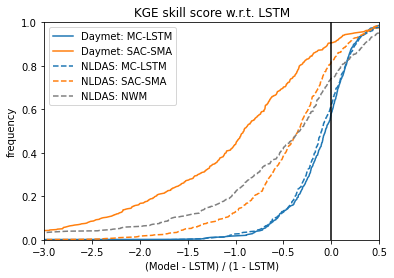

In [20]:
kgess_st2_dict = {forcing_type:{} for forcing_type in ['daymet','nldas']}
            
for forcing_type in ['daymet','nldas']:
    kgess_st2_dict[forcing_type]['MC-LSTM'] = (np.array(st2_dict[forcing_type]["KGE"]["mc"]) - \
                                                    np.array(st2_dict[forcing_type]["KGE"]["lstm"])) / \
                                                   (1 - np.array(st2_dict[forcing_type]["KGE"]["lstm"]))                        
for forcing_type in ['daymet','nldas']:
    kgess_st2_dict[forcing_type]['SAC-SMA'] = (np.array(st2_dict[forcing_type]["KGE"]["sac"]) - \
                                                    np.array(st2_dict[forcing_type]["KGE"]["lstm"])) / \
                                                   (1 - np.array(st2_dict[forcing_type]["KGE"]["lstm"]))
for forcing_type in ['nldas']:
    kgess_st2_dict[forcing_type]['NWM'] = (np.array(st2_dict[forcing_type]["KGE"]["nwm"]) - \
                                                    np.array(st2_dict[forcing_type]["KGE"]["lstm"])) / \
                                                   (1 - np.array(st2_dict[forcing_type]["KGE"]["lstm"]))
colz = ['#1f77b4', '#ff7f0e', '#2ca02c', '#bdbdbd']

yvalues = list(range(len(kgess_st1_dict['daymet']['SAC-SMA'])))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)        

    
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.sort(kgess_st2_dict['daymet']['MC-LSTM']), yvalues, label='Daymet: MC-LSTM', c=colz[0])
ax.plot(np.sort(kgess_st2_dict['daymet']['SAC-SMA']), yvalues, label='Daymet: SAC-SMA', c=colz[1])
ax.plot(np.sort(kgess_st2_dict['nldas']['MC-LSTM']), yvalues, label='NLDAS: MC-LSTM', c=colz[0], ls='--')
ax.plot(np.sort(kgess_st2_dict['nldas']['SAC-SMA']), yvalues, label='NLDAS: SAC-SMA', c=colz[1], ls='--')
ax.plot(np.sort(kgess_st2_dict['nldas']['NWM']), yvalues, label='NLDAS: NWM', c='grey', ls='--')
ax.plot([0,0], [0,1], c='k')
ax.set_xlim([-3,.5])
ax.set_ylim([0,1])
plt.legend()
plt.title("KGE skill score w.r.t. LSTM")
plt.xlabel("(Model - LSTM) / (1 - LSTM)")
plt.ylabel("frequency")

plt.show()
plt.close()